In [100]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [101]:
murder_rates = Table.read_table('C:/Users/velda/Downloads/Assignment 5/crime_rates.csv').select('State', 'Year', 'Population', 'Murder Rate')
murder_rates.set_format("Population", NumberFormatter)

State,Year,Population,Murder Rate
Alaska,1960,"226,167",10.2
Alaska,1961,"234,000",11.5
Alaska,1962,"246,000",4.5
Alaska,1963,"248,000",6.5
Alaska,1964,"250,000",10.4
Alaska,1965,"253,000",6.3
Alaska,1966,"272,000",12.9
Alaska,1967,"272,000",9.6
Alaska,1968,"277,000",10.5
Alaska,1969,"282,000",10.6


**Question 1.1.** What additional information will we need before we can check for that association?

1) What year(s) the death penalty was introduced in each state (if any).

2) Day to day data about when murders occurred.

3) What year(s) the death penalty was abolished in each state (if any).

4) Rates of other crimes in each state.

**Question 1.2.** Draw a line plot with years on the horizontal axis and murder rates on the 
vertical axis. Include two lines: one for Alaska murder rates and one for Minnesota murder rates. Create this plot using a single call, `ak_mn.plot('Year')`.

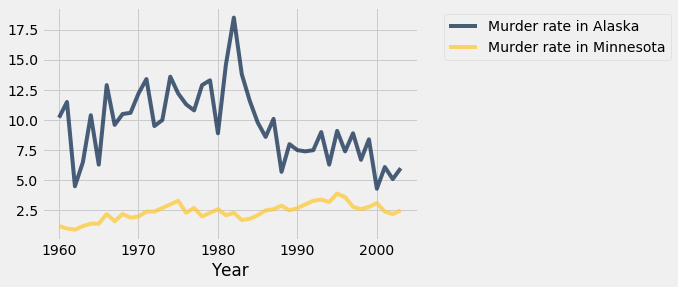

In [102]:
ak = murder_rates.where('State', 'Alaska').drop('State', 'Population').relabeled(1, 'Murder rate in Alaska')
mn = murder_rates.where('State', 'Minnesota').drop('State', 'Population').relabeled(1, 'Murder rate in Minnesota')

ak_mn = ak.join('Year',mn)
ak_mn.plot('Year')

**Question 1.3.** Implement the function `most_murderous`, which takes a year (an integer) as its argument. It does two things:
1. It draws a horizontal bar chart of the 5 states that had the highest murder rate in that year.
2. It returns an array of the names of these states in order of *increasing* murder rate.

Assume that the argument is a year in `murder_rates`. You do not need to check that it is.

array(['California', 'Mississippi', 'Texas', 'New York', 'Louisiana'],
      dtype='<U14')

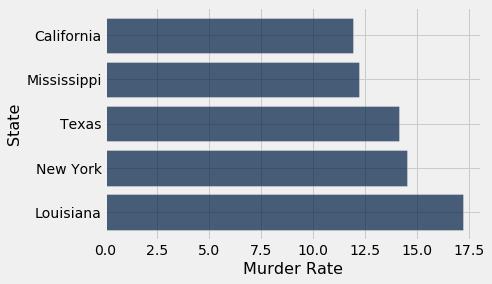

In [103]:
def most_murderous(year):
    # Assign most to a table of the most murderous states this year in ascending order.
    most = murder_rates.where('Year', year).sort('Murder Rate',descending = True).take(np.arange(5)).sort('Murder Rate')
    most.barh('State', 'Murder Rate')
    return most.column('State')

most_murderous(1990) # California, Mississippi, ..., 

**Question 1.4.** How many more people were murdered in California in 1988 than in 1975? Assign `ca_change` to the answer.

In [104]:
ca = murder_rates.where('State', are.equal_to('California'))
ca
ca_change = (ca.where('Year',1988).column(3).item(0)*ca.where('Year',1988).column(2).item(0)-ca.where('Year',1975).column(3).item(0)*ca.where('Year',1975).column(2).item(0))/100000
np.round(ca_change)

726.0

In [105]:
def diff_n(values, n):
    return np.array(values)[n:] - np.array(values)[:-n]

diff_n(make_array(1, 10, 100, 1000, 10000), 2)

array([  99,  990, 9900], dtype=int64)

**Question 2.1.** Implement the function `two_year_changes` that takes an array of murder rates for a state, ordered by increasing year. For all two-year periods (e.g., from 1960 to 1962), it computes and returns **the number of increases minus the number of decreases.**

In [106]:
def two_year_changes(rates):
    "Return the number of increases minus the number of decreases after two years."
    return np.count_nonzero(diff_n(rates,2)>0)-np.count_nonzero(diff_n(rates,2)<0)
#Implemented function two_year_changes in print function FYI.
print('Alaska:',    two_year_changes(ak.column('Murder rate in Alaska')))
print('Minnesota:', two_year_changes(mn.column('Murder rate in Minnesota')))

Alaska: -5
Minnesota: 6


**Question 2.2.** Assign `changes_by_state` to a table with one row per state that has two columns: the `State` name and the `Murder Rate two_year_changes` statistic computed across all years in our data set for that state.  



State,Murder Rate two_year_changes
Alabama,-6
Alaska,-5
Arizona,1
Arkansas,-1
California,17
Colorado,-4
Connecticut,4
Delaware,-3
Florida,-6
Georgia,-3


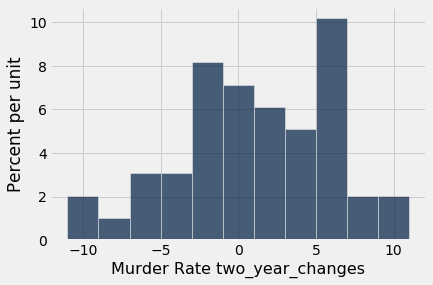

In [107]:
states = murder_rates.sort('State',distinct= True).column(0)
change = make_array()
for i in np.arange(len(states)):
    c = two_year_changes(murder_rates.where('State',states[i]).column(3))
    change = np.append(change,c)
changes_by_state = Table().with_columns('State',states,'Murder Rate two_year_changes',change)
# Here is a histogram of the two-year changes for the states.
# Since there are 50 states, each state contributes 2% to one
# bar.
changes_by_state.hist("Murder Rate two_year_changes", bins=np.arange(-11, 12, 2))
changes_by_state


**Question 2.3.** Assign `total_changes` to the total increases minus the total decreases for all two-year periods and all states in our data set. 


In [108]:
total_changes = sum(change)
print('Total increases minus total decreases, across all states and years:', total_changes)

Total increases minus total decreases, across all states and years: 45.0


**Question 2.4.** Set `num_changes` to the number of distinct two-year periods in the entire data set that could result in a change of a state's murder rate for all states. Include both those periods where a change occurred and the periods where a state's rate happened to stay the same.

In [122]:
pds = make_array()
for i in np.arange(len(states)):
    pd = murder_rates.where('State',states[i]).num_rows-2
    pds = np.append(pds,pd)
num_changes = sum(pds) 
num_changes

2100.0

We now have enough information to perform a hypothesis test.

> **Null Hypothesis**: State murder rates increase and decrease over two-year periods as if 
"increase" or "decrease" were sampled at random from a uniform distribution, like a fair coin flip.

Murder rates can be more likely to go up or more likely to go down. Since we observed 45 more increases than decreases for all two year periods in our dataset, we formulate an alternative hypothesis in accordance with our suspicion:

> **Alternative Hypothesis**: State murder rates are more likely to increase over two-year periods.


**Question 2.5** Given these null and alternative hypotheses, define a good test statistic.


Our test statistic should depend only on whether murder rates increased or decreased, not on the size of any change. Thus I choose:

> **Test Statistic**: The number of increases minus the number of decreases

The cell below samples increases and decreases at random from a uniform distribution 100 times. The final column of the resulting table gives the number of increases and decreases that resulted from sampling in this way.
**Using `sample_from_distribution` is faster than using `sample` followed by `group` to compute the same result.**

In [126]:
uniform = Table().with_columns(
    "Change", make_array('Increase', 'Decrease'),
    "Chance", make_array(0.5,        0.5))
uniform.sample_from_distribution('Chance', 100)

Change,Chance,Chance sample
Increase,0.5,59
Decrease,0.5,41


**Question 2.6.** Complete the simulation below, which samples `num_changes` increases/decreases at random many times and forms an empirical distribution of your test statistic under the null hypothesis.

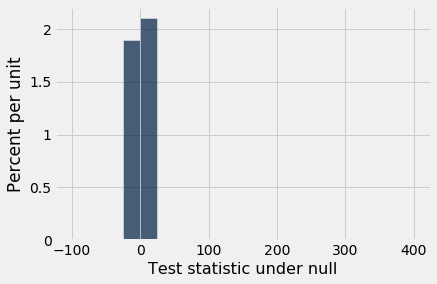

In [127]:
def simulate_under_null(num_chances_to_change):

    return uniform.sample_from_distribution('Chance', 100).column(2).item(0)-uniform.sample_from_distribution('Chance', 100).column(2).item(1)

uniform_samples = make_array()
for i in np.arange(5000):
    uniform_samples = np.append(uniform_samples, simulate_under_null(num_changes))

Table().with_column('Test statistic under null', uniform_samples).hist(0, bins=np.arange(-100, 400+25, 25))

**Question 2.7.** Looking at this histogram, draw a conclusion about whether murder rates basically increase as often as they decrease. You **do not** need to compute a P-value for this question.

First, set `which_side` to `"Right"` or `"Left"` depending on which side of the histogram you need to look at to make your conclusion. 

Then, set `reject_null` to `True` if rates increase more than they decrease, and we can reject the null hypothesis. Set `reject_null` to `False` if they do not systematically increase more than they decrease.

In [128]:
which_side = "Right"
if np.count_nonzero(uniform_samples>0)-np.count_nonzero(uniform_samples<0)>0:
    reject_null = True
else:
    reject_null = False
reject_null

False

**Question 3.1.** Describe this investigation in terms of an experiment. What population are we studying? What is the control group? What is the treatment group? What outcome are we measuring? Be precise!

- Population: All states in the United States
- Control Group: States without the death penalty in force during a given years
- Treatment Group: States with the death penalty in force during a given years
- Outcome: Increase or decrease in murder rate of a state during a given years

**Question 3.2.** We want to know whether the death penalty *causes* a change in the murder rate.  Why is it not sufficient to compare murder rates in places and times when the death penalty was in force with places and times when it wasn't?

Murder rates could be overall higher/lower in certain years across all states. Therefore, comparing states with the death penalty in one year vs without the death penalty in another year could give a biased estimate. In addition, some states will have an overall higher/lower murder rate due to confounding variables like time, population size, location, types of people, etc so we must control for this.

In [129]:
non_death_penalty_states = make_array('Alaska', 'Hawaii', 'Maine', 'Michigan', 'Wisconsin', 'Minnesota')
def had_death_penalty_in_1971(state):
    """Returns True if the argument is the name of a state that had the death penalty in 1971."""
    # The implementation of this function uses a bit of syntax
    # we haven't seen before.  Just trust that it behaves as its
    # documentation claims.
    return state not in non_death_penalty_states

states = murder_rates.group('State').select('State')
death_penalty = states.with_column('Death Penalty', states.apply(had_death_penalty_in_1971, 0))
death_penalty

State,Death Penalty
Alabama,True
Alaska,False
Arizona,True
Arkansas,True
California,True
Colorado,True
Connecticut,True
Delaware,True
Florida,True
Georgia,True


In [130]:
num_death_penalty_states = death_penalty.where("Death Penalty", are.equal_to(True)).num_rows
num_death_penalty_states

44

**Question 3.3.** Assign `death_penalty_murder_rates` to a table with the same columns and data as `murder_rates`, but that has only the rows for states that had the death penalty in 1971.

In [131]:
states = death_penalty.where('Death Penalty', True).column(0)
death_penalty_murder_rates = murder_rates.where('State',are.contained_in(states))
death_penalty_murder_rates

State,Year,Population,Murder Rate
Alabama,1960,"3,266,740",12.4
Alabama,1961,"3,302,000",12.9
Alabama,1962,"3,358,000",9.4
Alabama,1963,"3,347,000",10.2
Alabama,1964,"3,407,000",9.3
Alabama,1965,"3,462,000",11.4
Alabama,1966,"3,517,000",10.9
Alabama,1967,"3,540,000",11.7
Alabama,1968,"3,566,000",11.8
Alabama,1969,"3,531,000",13.7


The null hypothesis doesn't specify *how* the murder rate changes; it only talks about increasing or decreasing.  So, we will use the same test statistic we defined in section 2.

**Question 3.4.** Assign `test_stat_72` to the value of the test statistic for the years 1971 to 1973 and the states in `death_penalty_murder_rates`. 


In [132]:
t = death_penalty_murder_rates.where('Year', are.between(1971,1974))
states = t.sort('State', distinct = True).column(0)
stats = make_array()
for i in np.arange(len(states)):
    s = diff_n(t.where('State',states[i]).column(3), 2)
    stats = np.append(stats,s)
test_stat_72 = np.count_nonzero(stats>0)- np.count_nonzero(stats<0)
print('Test statistic from 1971 to 1973:', test_stat_72)

Test statistic from 1971 to 1973: 22


**Question 3.5.**: Draw an empirical histogram of the statistic under the null hypothesis by simulating the test statistic 5,000 times.

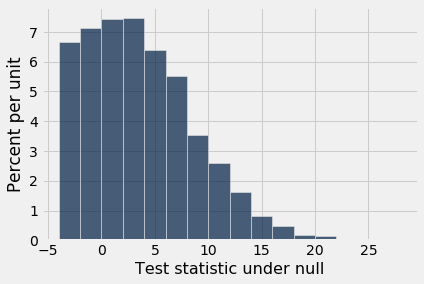

In [133]:
samples = make_array()
for i in np.arange(5000):
    sample = simulate_under_null(len(states))
    samples = np.append(samples, sample)
Table().with_column('Test statistic under null', samples).hist(bins=np.arange(-4, 28+2, 2))

### Conclusion
**Question 3.6.** Complete the analysis as follows:
1. Compute a P-value.
2. Draw a conclusion about the null and alternative hypotheses.
3. Describe your findings using simple, non-technical language.  Be careful not to claim that the statistical analysis has established more than it really has.

In [134]:
p = np.count_nonzero(samples>=test_stat_72)/5000
p

0.001

**P-value:** Look above result

**Conclusion about the hypotheses:** Because the p-value is less than 1%, it is highly statistically significant at the 1% level and we can reject the null hypothesis that each state's murder rate was equally likely to be higher or lower in the treatment period than in the control period and accept the alternative hypothesis. 

**Findings:** The statistical analysis shows that the murder rate was more likely to increase after the death penalty was removed. However, no causation can be proved, only correlation.

**Question 4.1.** Implement `run_test`, which takes the following arguments:

- A table of murder `rates` for certain states, sorted by state and year like `murder_rates`, and
- the year when the analysis starts.  (The comparison group is two years later.)

In [135]:
def run_test(rates, start_year):

    states1 = rates.sort('State',distinct = True).column('State')
    end_year = start_year + 2
    year = rates.where('Year',are.between(start_year,end_year+1))
    
    stats = make_array()
    for i in np.arange(len(states1)):
        s = diff_n(year.where('State',states1[i]).column(3), 2)
        stats = np.append(stats,s)
    observed_test_statistic = np.count_nonzero(stats>0)-np.count_nonzero(stats<0)
    print('Test statistic', start_year, 'to', end_year, ':', observed_test_statistic)
    num_states = rates.group('State').num_rows
    
    samples = make_array()
    for i in np.arange(5000):
        sample = simulate_under_null(len(states1))
        samples = np.append(samples, sample)
    if observed_test_statistic > 0:
        p = np.count_nonzero(samples>observed_test_statistic)/5000
        return p
    elif observed_test_statistic < 0:
        p = np.count_nonzero(samples<observed_test_statistic)/5000
        return p
    
run_test(death_penalty_murder_rates, 1971)
p

Test statistic 1971 to 1973 : 22


0.001

**Question 4.3.** Now we've analyzed states where the death penalty went away and came back, as well as states where the death penalty was outlawed all along.  What do you conclude from  the results of the tests we have conducted so far? Does all the evidence consistently point toward one conclusion, or is there a contradiction?


**Our results point toward the conclusion that the death penalty moratorium increased murder rates, but we have not accounted for time as a confounding factor**


**Question 5.1.** Create a table called `average_murder_rates` with 1 row for each year in `murder_rates`.  It should have 3 columns:
* `Year`, the year,
* `Death penalty states`, the average murder rate of the states that had the death penalty in 1971, and
* `No death penalty states`, the average murder rate of the other states.

In [136]:
years = murder_rates.sort('Year',distinct = True).column('Year')
death = murder_rates.where('State',are.contained_in(states)).group('Year',np.mean).column(3)
no_death = murder_rates.where('State',are.contained_in(non_death_penalty_states)).group('Year',np.mean).column(3)
average_murder_rates = Table().with_columns('Year',years,'Death penalty states',death,'No death penalty states',no_death)
average_murder_rates

Year,Death penalty states,No death penalty states
1960,5.27955,3.55
1961,4.77727,3.68333
1962,4.61591,2.33333
1963,4.61364,2.75
1964,4.71136,3.4
1965,4.82727,3.18333
1966,5.43182,4.51667
1967,5.875,3.73333
1968,6.27045,4.73333
1969,6.50227,4.73333


**Question 5.2.** Describe in **one short sentence** a high-level takeaway from the line plot below. Are the murder rates in these two groups of states related?

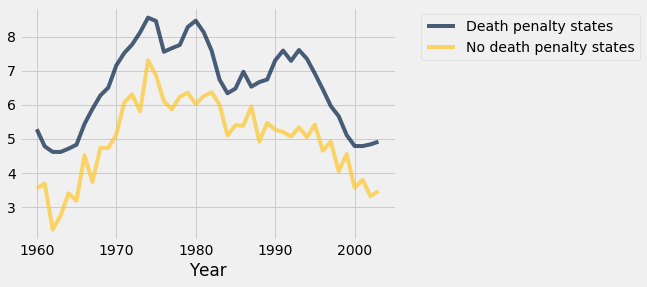

In [137]:
average_murder_rates.plot('Year')

### Murder rates seem to rise and fall together with a similar trend across all states, both with and without the death penalty, but those states without the death penalty consistently have a lower murder rate during this time period.

Let's bring in another source of information: Canada.

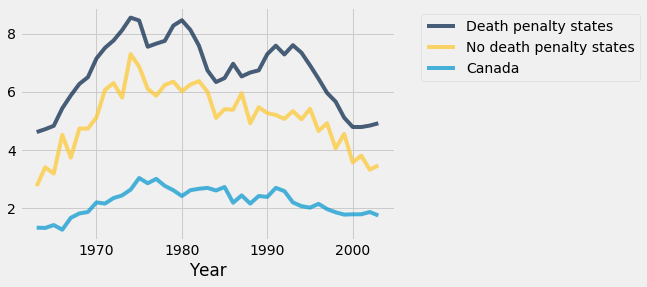

In [138]:
canada = Table.read_table('C:/Users/velda/Downloads/Assignment 5/canada.csv')
murder_rates_with_canada = average_murder_rates.join("Year", canada.select("Year", "Homicide").relabeled("Homicide", "Canada"))
murder_rates_with_canada.plot('Year')

**Question 5.3.** Complete their argument in 2-3 sentences; what features of these plots indicate that the death penalty is not an important factor in determining the murder rate?

We cannot attribute the increases to U.S. homicide rates between 1972-76 to the abolition of the death penalty; prior to the abolishment, murder rates had been steadily increasing for about 9 years (1963-1972) both in the U.S. and Canada. After the death penalty was reestablished in the U.S. until 2001, we see U.S. murder rates slowly decrease overtime with spikes around 1982 and 1992. In Canada, although they abolished the death penalty much earlier in 1967, murder rates also follow the same general trend: a decrease in this time period with spikes around 1982 and 1992. Murder rates seem to follow a similar trend across differnt countries, unrelated to whether or not the region had the death penalty estabished as law.

**Question 5.5.** What assumption(s) did we make in Parts 1 through 4 of the project that led us to believe that the death penalty deterred murder, when in fact the line plots tell a different story?

The plot shows that neither the abolishment nor the institution of the death penalty is the direct cause for changes in murder rates. Evidence from the project also supports this. Firstly, variables such as location and time prevent us from assuming causation. Although we controlled for differences among states by using a natural experiment, our study was limited to the United States, and did not account for trends in other countries. Moreover, trend lines in groups of U.S. states with and without the death penalty follow the same pattern, further emphasizing possible confounding factors that could have an effect on murder rates other than the death penalty. There does not seem to be a causal relationship between increases and decreases to murder rates and whether or not a state has the death penalty.
